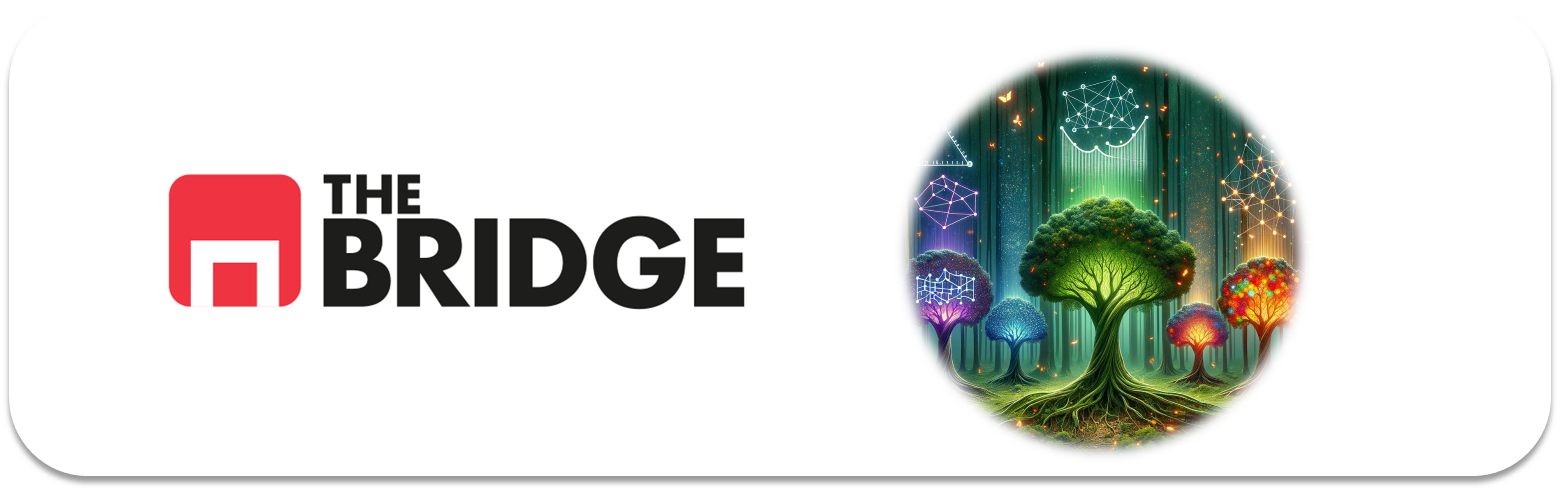

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import bootcampviztools as bt

np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

## Problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto
Objetivo: Decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo

In [40]:
df_bank = pd.read_csv("./data/bank-full.csv", sep = ";")
df_bank.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,no
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,no
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,no
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,no
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,no


In [4]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df_bank['contact'].value_counts(True)

contact
cellular     0.647741
unknown      0.287983
telephone    0.064276
Name: proportion, dtype: float64

In [7]:
df_bank['previous'].value_counts(True)

previous
0      0.817367
1      0.061313
2      0.046582
3      0.025259
4      0.015793
5      0.010152
6      0.006127
7      0.004534
8      0.002853
9      0.002035
10     0.001482
11     0.001438
12     0.000973
13     0.000841
15     0.000442
14     0.000420
17     0.000332
16     0.000288
19     0.000243
23     0.000177
20     0.000177
18     0.000133
22     0.000133
24     0.000111
27     0.000111
29     0.000088
21     0.000088
25     0.000088
30     0.000066
26     0.000044
37     0.000044
28     0.000044
38     0.000044
51     0.000022
275    0.000022
58     0.000022
32     0.000022
40     0.000022
55     0.000022
35     0.000022
41     0.000022
Name: proportion, dtype: float64

In [8]:
df_bank['poutcome'].value_counts(True)

poutcome
unknown    0.817478
failure    0.108403
other      0.040698
success    0.033421
Name: proportion, dtype: float64

In [41]:
train_set, test_set = train_test_split(df_bank, test_size= 0.2, random_state= 42)

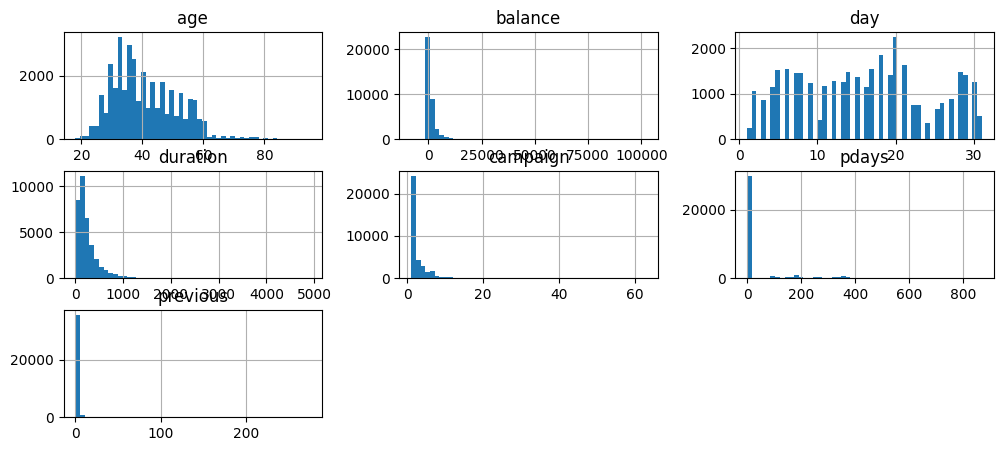

In [14]:
train_set.hist(bins=50, figsize=(12, 5))
len(train_set)
plt.show()

In [21]:
corr = train_set.corr(numeric_only = True)
corr

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.098921,-0.007882,-0.007414,0.003160,-0.023231,0.002397
balance,0.098921,1.000000,0.000455,0.025590,-0.018566,0.002122,0.015291
day,-0.007882,0.000455,1.000000,-0.025719,0.160599,-0.094405,-0.053229
duration,-0.007414,0.025590,-0.025719,1.000000,-0.086526,-0.001179,0.002557
campaign,0.003160,-0.018566,0.160599,-0.086526,1.000000,-0.089317,-0.033300
pdays,-0.023231,0.002122,-0.094405,-0.001179,-0.089317,1.000000,0.440662
previous,0.002397,0.015291,-0.053229,0.002557,-0.033300,0.440662,1.000000


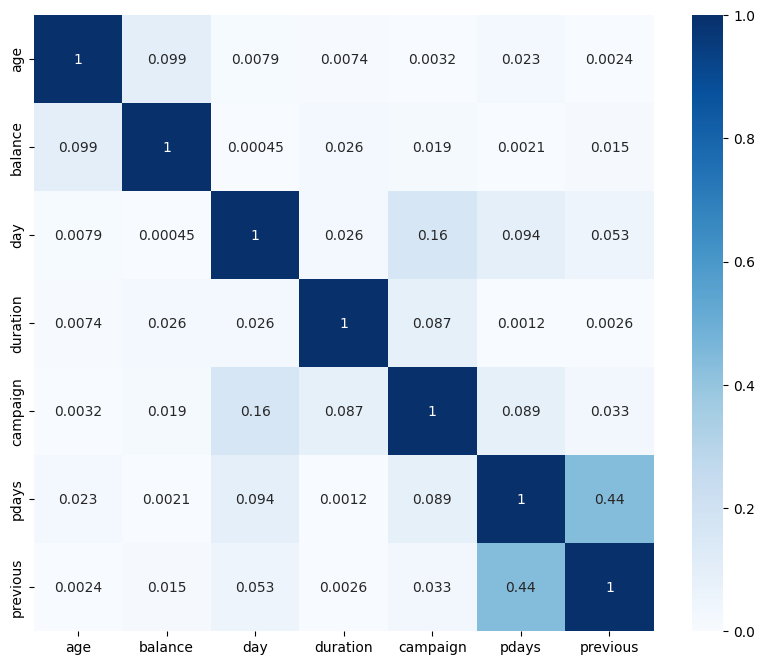

In [25]:
plt.figure(figsize = (10,8))

sns.heatmap(np.abs(train_set.corr(numeric_only = True)), annot = True, cmap = "Blues", vmin=0, vmax=1)
plt.show();

In [48]:
# feature categoricas incluido target 
train_set["default"] = train_set["default"] == "yes"
test_set["default"] = test_set["default"] == "yes"
train_set["housing"] = train_set["housing"] == "yes"
test_set["housing"] = test_set["housing"] == "yes" 
train_set["loan"] = train_set["loan"] == "yes"
test_set["loan"] = test_set["loan"] == "yes"

In [45]:
features_cat= ['job', 'marital', 'education', 'contact', 'poutcome']

train_set = pd.get_dummies(train_set, columns = features_cat, dtype = int)
test_set = pd.get_dummies(test_set, columns = features_cat, dtype = int)

In [65]:
features = list(train_set.columns)
features

['age',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'y',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown']

In [67]:
features_remove = train_set.select_dtypes(include = "object").columns.to_list()
for ind,x in enumerate(features_remove):
    features.remove(features_remove[ind])
features

['age',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown']

In [68]:
#Features
X = train_set[features]
#target #-> y 
y = train_set['y'] 

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


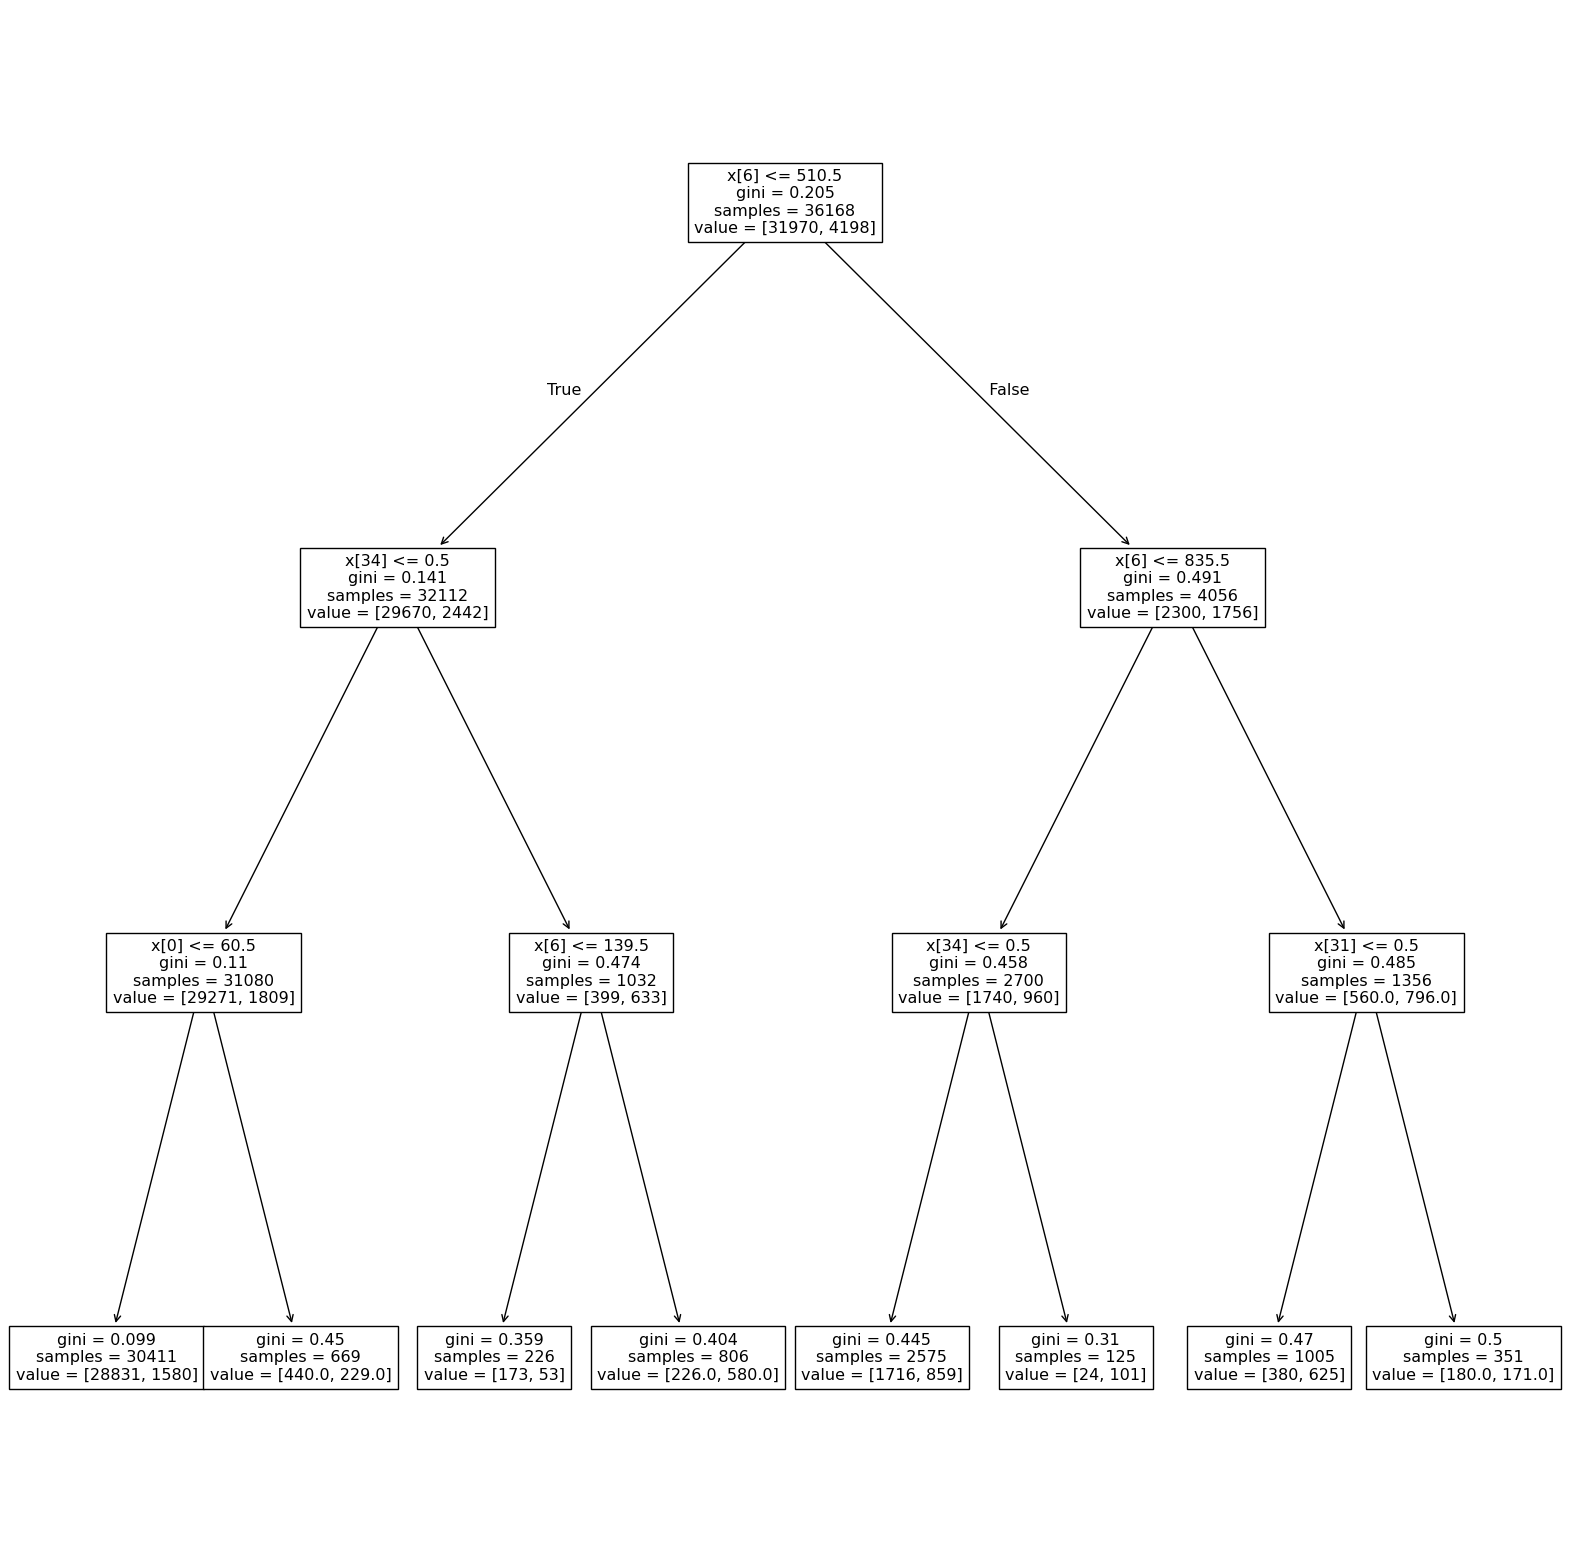

In [82]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(tree_clf);

In [81]:
print(classification_report(y, tree_clf.predict(X)))

              precision    recall  f1-score   support

          no       0.92      0.98      0.95     31970
         yes       0.67      0.31      0.43      4198

    accuracy                           0.90     36168
   macro avg       0.80      0.65      0.69     36168
weighted avg       0.89      0.90      0.89     36168



In [83]:
X_test = test_set[features]
y_test = test_set['y'] 
print(classification_report(y_test, tree_clf.predict(X_test)))

              precision    recall  f1-score   support

          no       0.91      0.98      0.94      7952
         yes       0.65      0.30      0.41      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043

